In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Extract values from matrix; this is QUBO specific, but the rest of the code can take nonquadratic functions as well.

In [2]:
def qubo_values(QuadraticForm):
    phi = np.empty(1 << QuadraticForm.shape[0], dtype=int)
    for idx, conf in enumerate((np.arange(phi.shape[0]).reshape(-1, 1) >> np.arange(QuadraticForm.shape[0]))%2):
        phi[idx] = np.dot(conf@QuadraticForm, conf)        
    
    return phi

In [56]:
def fpgas_updater(p, delta, l, p0):
    F = np.cumsum(p0)

    p_new = np.zeros(p.shape[0])
    for idx, [py, Fy] in enumerate(zip(p[:-1], F[:-1])):
        inner_chebishev = np.cosh(np.arccosh(1 / delta) / (2 * l + 1)) * np.sqrt(Fy)
        if inner_chebishev <= 1:
            P_failure = np.square(np.cos(np.arccos(inner_chebishev) * (2 * l + 1))  * delta)
        else:
            P_failure = np.square(np.cosh(np.arccosh(inner_chebishev) * (2 * l + 1))  * delta)

        p_new[idx+1:-1] += py * (1 - P_failure) * p0[idx+1:-1] / (1 - Fy)
        p_new[idx] += py * P_failure

    p_new[-1] = 1 - np.sum(p_new[:-1])

    return p_new

In [60]:
def gas_updater(p, m, p0):
    F = 1 - np.cumsum(p0)

    thetas = 2 * np.arcsin(np.sqrt(F[:-1])) / np.pi
    P_failures = (1 + np.sinc(2 * m * thetas) / np.sinc(thetas)) / 2

    p_new = np.zeros(p.shape[0])
    p_new[:-1] = p[:-1] * P_failures
    for idx, [py, Fy, P_failure] in enumerate(zip(p[:-1], F[:-1], P_failures), start=1):
        p_new[idx:-1] += py * (1 - P_failure) * p0[idx:-1] / Fy
        #p_new[idx] += py * P_failure

    p_new[-1] = 1 - np.sum(p_new[:-1])

    return p_new

# graph to generate QUBO for testing

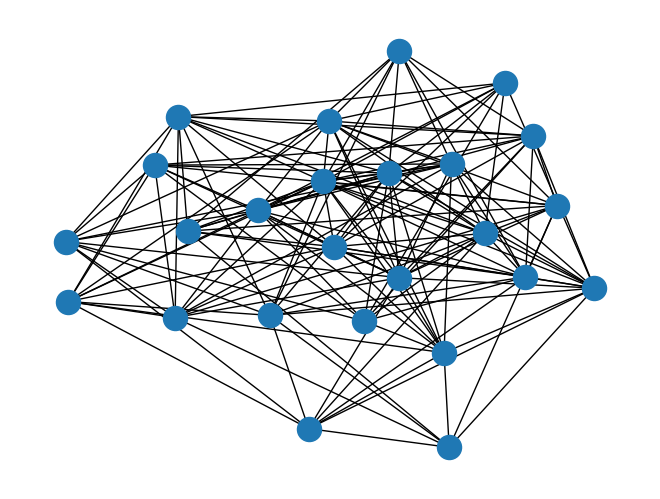

In [38]:
# random, connected graph
NumberOfVertices, EdgeProbability = 25, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
while not nx.is_connected(Graph):
    Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
nx.draw(Graph, with_labels=False)
GraphLaplacian = nx.laplacian_matrix(Graph).toarray()

# let's get rid of the vertex with the highest degree; this step is not necessary, but saves one qubit
maxdegvertex = np.argmax(np.diag(GraphLaplacian))
Q = np.delete(np.delete(GraphLaplacian, maxdegvertex, 0), maxdegvertex, 1)

cuts = qubo_values(Q)
MaxCut = np.max(cuts)

cut_values = np.unique(cuts)
p0 = np.array([np.count_nonzero(cuts == cut) for cut in cut_values]) / cuts.shape[0]

# simulation

In [46]:
rounds = 10 # number of iterations to run

In [47]:
Lambda = 6/5 # paramaters for GAS; Lambda = 6/5 is from Boyer et al.

In [48]:
delta, alpha = 0.4, 2 # paramaters for FPGAS / far from optimal at such a low qubit number

In [61]:
# runing the simulation
p_gas = np.copy(p0)
p_fpgas = np.copy(p0)
l = 1
m = 1
for idx in range(rounds):
    p_fpgas, p_gas = fpgas_updater(p_fpgas, delta, np.ceil(l), p0), gas_updater(p_gas, np.ceil(m), p0)
    m *= Lambda
    l *= alpha

# statistics

In [64]:
E_random = np.dot(p0, cut_values)
E_gas = np.dot(p_gas, cut_values)
E_fpgas = np.dot(p_fpgas, cut_values)

cut_values_squared = np.square(cut_values)

sigma_random = np.sqrt(np.dot(p0, cut_values_squared) - E_random**2)
sigma_gas = np.sqrt(np.dot(p_gas, cut_values_squared) - E_gas**2)
sigma_fpgas = np.sqrt(np.dot(p_fpgas, cut_values_squared) - E_fpgas**2)

In [65]:
print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t---------------------")
print(f"\t\trandom\tGAS\tFPGAS\n")
print(f"E[cut]\t\t{(E_random / MaxCut):.2%}\t{(E_gas / MaxCut):.2%}\t{(E_fpgas / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_random / MaxCut):.2%}\t{(sigma_gas / MaxCut):.2%}\t{(sigma_fpgas / MaxCut):.2%}")

		maximal cut	= 98
		---------------------
		random	GAS	FPGAS

E[cut]		76.02%	88.36%	96.35%
D[cut]		6.23%	2.56%	2.14%


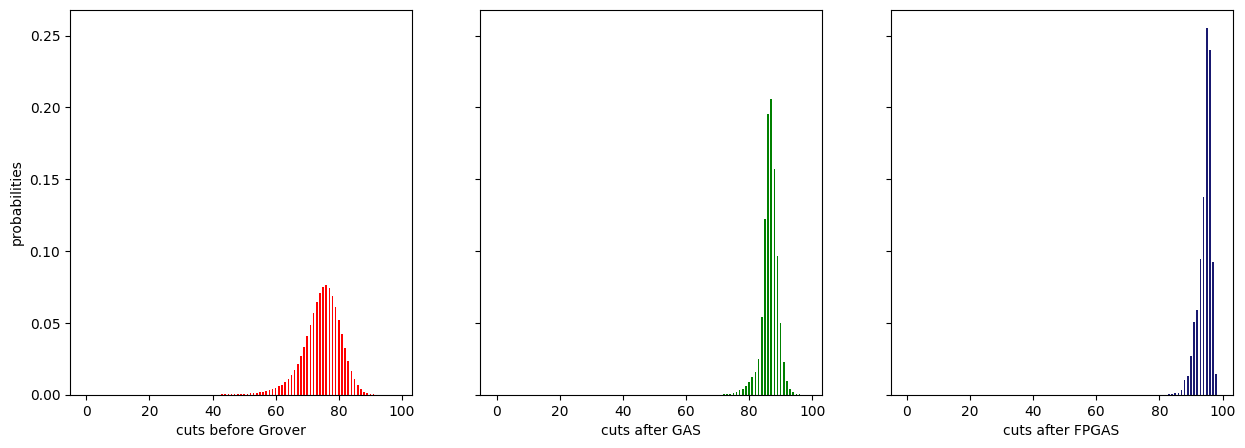

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(cut_values,
           p0,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")

axs[1].bar(cut_values,
           p_gas,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after GAS")

axs[2].bar(cut_values,
           p_fpgas,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"cuts after FPGAS")

plt.show()

# probabilities of finding MaxCut

In [67]:
print(f"{p0[-1]:.4%}\t{p_gas[-1]:.4%}\t{p_fpgas[-1]:.4%}")

0.0000%	0.0007%	1.4272%


# improvemnts

In [71]:
p_fpgas[-1] / p0[-1], p_fpgas[-1] / p_gas[-1]

(np.float64(239451.00699512847), np.float64(2169.691060811774))

# with repetition

In [72]:
def repeater(distribution, r):
    CDF = np.power(np.cumsum(distribution), r)
    distribution_new = CDF - np.roll(CDF, 1)
    distribution_new[0] = CDF[0]
    return distribution_new    

In [73]:
reps = NumberOfVertices**2

In [74]:
# cut statistics
p0_with_reps = repeater(p0, reps)
p_gas_with_reps = repeater(p_gas, reps)
p_fpgas_with_reps = repeater(p_fpgas, reps)

In [75]:
E_random_with_reps = np.dot(p0_with_reps, cut_values)
E_gas_with_reps = np.dot(p_gas_with_reps, cut_values)
E_fpgas_with_reps = np.dot(p_fpgas_with_reps, cut_values)

sigma_random_with_reps = np.sqrt(np.dot(p0_with_reps, cut_values_squared) - E_random_with_reps)
sigma_gas_with_reps = np.sqrt(np.dot(p_gas_with_reps, cut_values_squared) - E_gas_with_reps)
sigma_fpgas_with_reps = np.sqrt(np.dot(p_fpgas_with_reps, cut_values_squared) - E_fpgas_with_reps)

In [76]:
print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t---------------------")
print(f"\t\tnumber of reps\t= {reps}\n\t\t---------------------")
print(f"\t\trandom\tGAS\tFPGAS\n")
print(f"E[cut]\t\t{(E_random_with_reps / MaxCut):.2%}\t{(E_gas_with_reps / MaxCut):.2%}\t{(E_fpgas_with_reps / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_random_with_reps / MaxCut):.2%}\t{(sigma_gas_with_reps / MaxCut):.2%}\t{(sigma_fpgas_with_reps / MaxCut):.2%}")

		maximal cut	= 98
		---------------------
		number of reps	= 625
		---------------------
		random	GAS	FPGAS

E[cut]		91.18%	96.26%	100.00%
D[cut]		90.68%	95.75%	99.49%


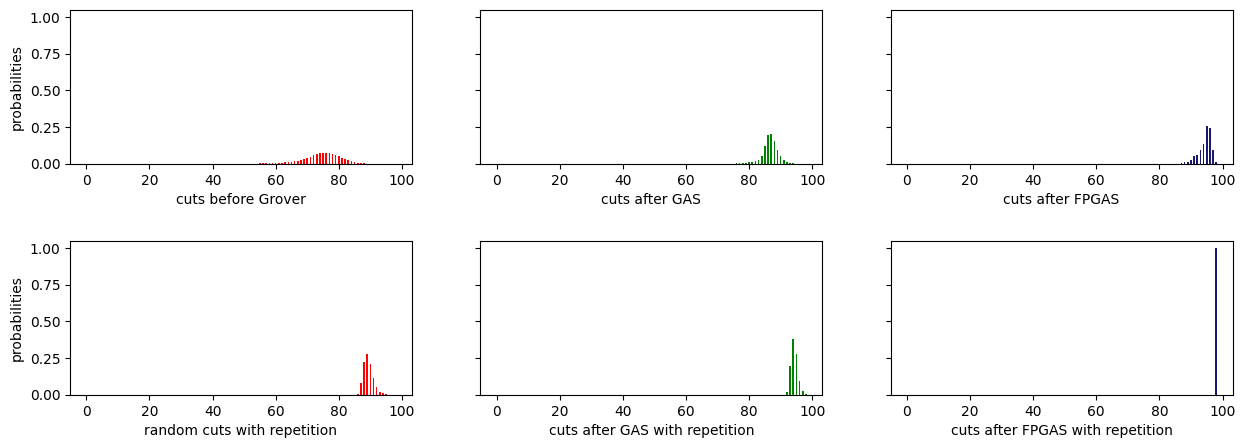

In [77]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15, 5))

axs[0, 0].bar(cut_values,
           p0,
           width=0.5,
           color="red")
axs[0, 0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")

axs[0, 1].bar(cut_values,
           p_gas,
           width=0.5,
           color="green")
axs[0, 1].set(xlabel=f"cuts after GAS")

axs[0, 2].bar(cut_values,
           p_fpgas,
           width=0.5,
           color="midnightblue")
axs[0, 2].set(xlabel=f"cuts after FPGAS")

axs[1, 0].bar(cut_values,
           p0_with_reps,
           width=0.5,
           color="red")
axs[1, 0].set(xlabel=f"random cuts with repetition",
           ylabel=f"probabilities")

axs[1, 1].bar(cut_values,
           p_gas_with_reps,
           width=0.5,
           color="green")
axs[1, 1].set(xlabel=f"cuts after GAS with repetition")

axs[1, 2].bar(cut_values,
           p_fpgas_with_reps,
           width=0.5,
           color="midnightblue")
axs[1, 2].set(xlabel=f"cuts after FPGAS with repetition")

plt.subplots_adjust(hspace=0.5)

plt.show()